In [1]:
# !pip install wandb

In [2]:
import numpy as np 
import pandas as pd 
import os
import wandb
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import Module, Sequential, Conv2d, ConvTranspose2d, LeakyReLU, BatchNorm2d, ReLU, Tanh, Sigmoid, BCELoss , AvgPool2d, Linear
import torchvision.utils as vutils

%matplotlib inline

In [3]:
print("DATASET LOADED")

DATASET LOADED


In [4]:
!wandb login 08836028c4159212c320516a4f9103655dbf9ae6

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
wandb.init(project="PEG", entity="bhuvanesh_ai")

wandb: Currently logged in as: bhuvanesh_ai. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240313_072437-8ax2ziji
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run clean-sunset-27
wandb: ⭐️ View project at https://wandb.ai/bhuvanesh_ai/PEG
wandb: 🚀 View run at https://wandb.ai/bhuvanesh_ai/PEG/runs/8ax2ziji


In [6]:
dir_data = "/kaggle/input/procedural-environment-generation/dataset/dataset"
img_shape = (256,256,1)
img_paths = [dir_data + '/' + file for file in os.listdir(dir_data)]
img_paths = img_paths[:-6]

In [7]:
img_paths = np.sort(img_paths)

In [8]:
def load_images(img_paths):
    for image in img_paths:
        img = Image.open(image)
        img_array = np.array(img)
        img_array_normalized = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array))
        
        yield np.transpose(np.expand_dims(np.float32(img_array_normalized), axis = 2),(2,0,1))

In [9]:
def plot_images(imgs, grid_size = 5):

    fig = plt.figure(figsize = (6,6))
    plt.axis("off")
    columns = rows = grid_size
    plt.title("Training Images")
    images = load_images(imgs)
    for i in range(1, columns*rows +1):
        
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.imshow(np.transpose(next(images), (1,2,0)), cmap = 'gray')
        
    plt.show()

In [10]:
images = load_images(img_paths)
image = next(images)

In [11]:
image.size

65536

In [12]:
dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)

In [13]:
device

device(type='cuda', index=0)

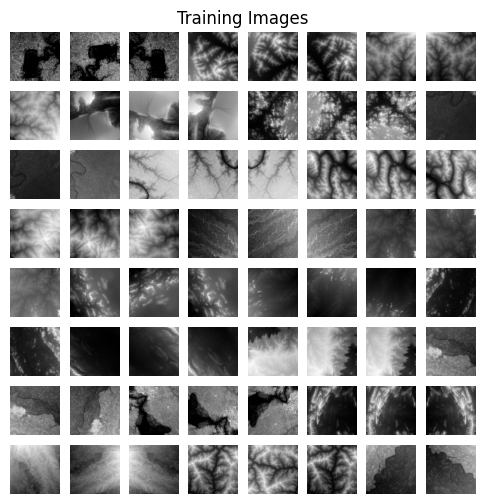

In [14]:
plot_images(img_paths, 8)

In [15]:
class Terrains(Dataset):
    def __init__(self, img_paths):
        '''np array containing all paths to all images'''
        self.img_paths = img_paths
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = next(load_images([self.img_paths[idx]]))
        return image

In [16]:
dset = Terrains(img_paths)
batch_size = 128
shuffle = True

In [17]:
dataloader = DataLoader(dataset = dset, batch_size = batch_size, shuffle = shuffle, num_workers = 2)

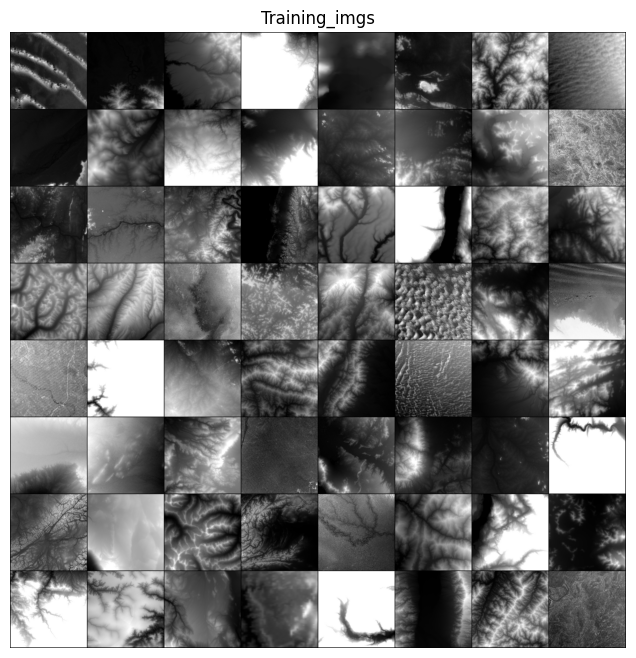

In [18]:
real_batch = next(iter(dataloader))
plt.figure(figsize = (8,8))
plt.axis("off")
plt.title("Training_imgs")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding = 2, normalize=True).cpu(),(1,2,0)), cmap='gray')
plt.show()

In [19]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [20]:
D_lr = 0.00005
G_lr = 0.00005
FILTER_SIZE = 8
BATCH_SIZE = 128

In [21]:
s = 256
s2, s4, s8 = int(s/2), int(s/4), int(s/8)
g_dim = 64
c_dim = 1

In [22]:
# class Generator(Module):
    
    
#     def __init__(self, batch_size, reuse = False):
#         super().__init__()
               
#         output2_shape = [batch_size, g_dim, s4 , s4 ]
#         self.b_conv2 = nn.Parameter(torch.ones(output2_shape[1]) * 0.1)
#         self.resize_layer2 = nn.Upsample(size=(output2_shape[2], output2_shape[3]), mode='nearest')
#         self.conv2 = nn.Conv2d(in_channels=g_dim, out_channels=s4, kernel_size=(FILTER_SIZE, FILTER_SIZE), padding='same')
#         self.batch_norm2 = nn.BatchNorm2d(s4)
        
#         output3_shape = [batch_size,g_dim*2, s2 , s2 ]
#         self.b_conv3 = nn.Parameter(torch.ones(output3_shape[1]) * 0.1)
#         self.resize_layer3 = nn.Upsample(size=(output3_shape[2], output3_shape[3]), mode='nearest')
#         self.conv3 = nn.Conv2d(in_channels=g_dim, out_channels=s8, kernel_size=(FILTER_SIZE, FILTER_SIZE), padding='same')
#         self.batch_norm3 = nn.BatchNorm2d(s8)
        
#         output4_shape = [batch_size, c_dim, s, s]
#         self.b_conv4 = nn.Parameter(torch.ones(output4_shape[1]) * 0.1)
#         self.resize_layer4 = nn.Upsample(size=(output4_shape[2], output4_shape[3]), mode='nearest')
#         self.conv4 = nn.Conv2d(in_channels=s8, out_channels=1, kernel_size=(FILTER_SIZE, FILTER_SIZE), padding='same')
        
#     def forward(self, z):
#         batch_temp = z.shape[0]
#         h0 = torch.reshape(z, [batch_temp, 64,s8,s8])
#         h0 = LeakyReLU()(h0)
# #         print(h0.shape)
#         h_conv2 = self.resize_layer2(h0) + self.b_conv2
# #         print(h_conv2.shape)
#         h_conv2 = self.conv2(h_conv2)
# #         print(h_conv2.shape)
#         h_conv2 = LeakyReLU()(h_conv2)
#         h_conv2 = self.batch_norm2(h_conv2)
#         h_conv2 = LeakyReLU()(h_conv2)
        
#         h_conv3 = self.resize_layer3(h_conv2) + self.b_conv3
# #         print(h_conv3.shape)
#         h_conv3 = self.conv3(h_conv3)
# #         print(h_conv3.shape)
#         h_conv3 = LeakyReLU()(h_conv3)
#         h_conv3 = self.batch_norm3(h_conv3)
#         h_conv3 = LeakyReLU()(h_conv3)
        
#         h_conv4 = self.resize_layer4(h_conv3) + self.b_conv4
# #         print(h_conv4.shape)
#         h_conv4 = self.conv4(h_conv4)
# #         print(h_conv4.shape)
#         h_conv4 = LeakyReLU()(h_conv4)
#         h_conv4 = Tanh()(h_conv4)
        
#         return h_conv4

In [23]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is a random noise vector of size nz
            # Output: (ngf * 16) x 4 x 4 (initial layer is doubled for larger image)
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            # Output: (ngf * 8) x 8 x 8
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # Output: (ngf * 4) x 16 x 16
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # Output: (ngf * 2) x 32 x 32
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # Output: (ngf) x 64 x 64
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # Output: (nc) x 256 x 256
            nn.ConvTranspose2d(ngf, nc, 4, 4, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [24]:
# class Discriminator(Module):
#     def __init__(self):
#         super().__init__()
#         self.leaky_relu = LeakyReLU()
#         #256x256x1
#         self.conv1 = Conv2d(in_channels=1, out_channels= 8 , kernel_size = 5, stride = 1, padding=1, bias = False)
#         #leaky relu here
#         #256x256x8
#         self.pool1 = AvgPool2d(kernel_size=2, stride = 2, padding = 1)
#         #128x128x8
#         self.conv2 = Conv2d(in_channels=8, out_channels= 16 , kernel_size = 5, stride = 1, padding=1,  bias = False)
# #         LeakyRelu here
#         #128x128x16
#         self.pool2 = AvgPool2d(kernel_size=2, stride = 2, padding = 1)
#         #64x64x16
#         #add flatten
#         self.dimval = 64*64*16
        
#         self.fc1 = Linear(self.dimval, 32,  bias = False)
# #         LeakyReLU here
#         self.fc2 = Linear(32, 1,  bias = False)
# #         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, inputs):
# #         print(inputs.shape)
#         x = self.conv1(inputs)
# #         print(x.shape)
#         x = self.leaky_relu(x)
# #         print(x.shape)
#         x = self.pool1(x)
# #         print(x.shape)
#         x = self.conv2(x)
# #         print(x.shape)
#         x = self.leaky_relu(x)
# #         print(x.shape)
#         x = self.pool2(x)
# #         print(x.shape)
        
#         x = torch.reshape(x, [x.shape[0], self.dimval])
        
#         x = self.fc1(x)
#         x = self.leaky_relu(x)
        
#         x =  self.fc2(x)
# #         output = self.sigmoid(x)
#         return x

In [25]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 256 x 256
            nn.Conv2d(nc, ndf, 4, 4, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input)

In [26]:
ngpu = 2
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

In [27]:
checkpoint = torch.load("/kaggle/input/lastgan/last_GAN.pt")

In [28]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
# netG.apply(weights_init)
netG.load_state_dict(checkpoint['Gen_state_dict'])

# Print the model
print(netG)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), strid

In [29]:
netD = Discriminator(ngpu).to(device)
# # Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
# netD.apply(weights_init)
netD.load_state_dict(checkpoint['Disc_state_dict'])


# Print the model
print(netD)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(4, 4), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    )
  )
)


In [30]:
def filtered_params(model):
    return [param for name, param in model.named_parameters() if 'batch' not in name]
params = filtered_params(netG)

In [31]:
fixed_noise = torch.randn(batch_size, 100, 1,1,device = device)

In [32]:
real_label = 1
fake_label = 0

In [33]:
workers = 2
num_epochs = 361
beta1 = 0.5

In [34]:
optimizerD = optim.RMSprop(netD.parameters(), lr = D_lr)
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
optimizerG = optim.RMSprop(netG.parameters(), lr = G_lr)
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])

In [35]:
device

device(type='cuda', index=0)

In [36]:
!mkdir checkpoints

Starting Training Loop...
[361/361][0/660]	Loss_D: -0.0655	Loss_G: -0.1438	D(x): 0.1928	D(G(z)): 0.1273 / 0.1438
[361/361][50/660]	Loss_D: -0.0616	Loss_G: -0.1453	D(x): 0.1899	D(G(z)): 0.1284 / 0.1453
[361/361][100/660]	Loss_D: -0.0875	Loss_G: -0.1836	D(x): 0.2042	D(G(z)): 0.1167 / 0.1836
[361/361][150/660]	Loss_D: -0.0409	Loss_G: -0.2197	D(x): 0.2252	D(G(z)): 0.1843 / 0.2197
[361/361][200/660]	Loss_D: -0.0525	Loss_G: -0.1284	D(x): 0.1452	D(G(z)): 0.0927 / 0.1284
[361/361][250/660]	Loss_D: -0.0569	Loss_G: -0.2161	D(x): 0.2067	D(G(z)): 0.1498 / 0.2161
[361/361][300/660]	Loss_D: -0.0758	Loss_G: -0.1278	D(x): 0.2472	D(G(z)): 0.1714 / 0.1278
[361/361][350/660]	Loss_D: -0.0677	Loss_G: -0.0872	D(x): 0.2699	D(G(z)): 0.2022 / 0.0872
[361/361][400/660]	Loss_D: -0.0699	Loss_G: -0.0645	D(x): 0.2497	D(G(z)): 0.1798 / 0.0645
[361/361][450/660]	Loss_D: -0.0628	Loss_G: -0.1766	D(x): 0.2994	D(G(z)): 0.2366 / 0.1766
[361/361][500/660]	Loss_D: -0.0638	Loss_G: -0.1625	D(x): 0.2300	D(G(z)): 0.1662 / 0.162

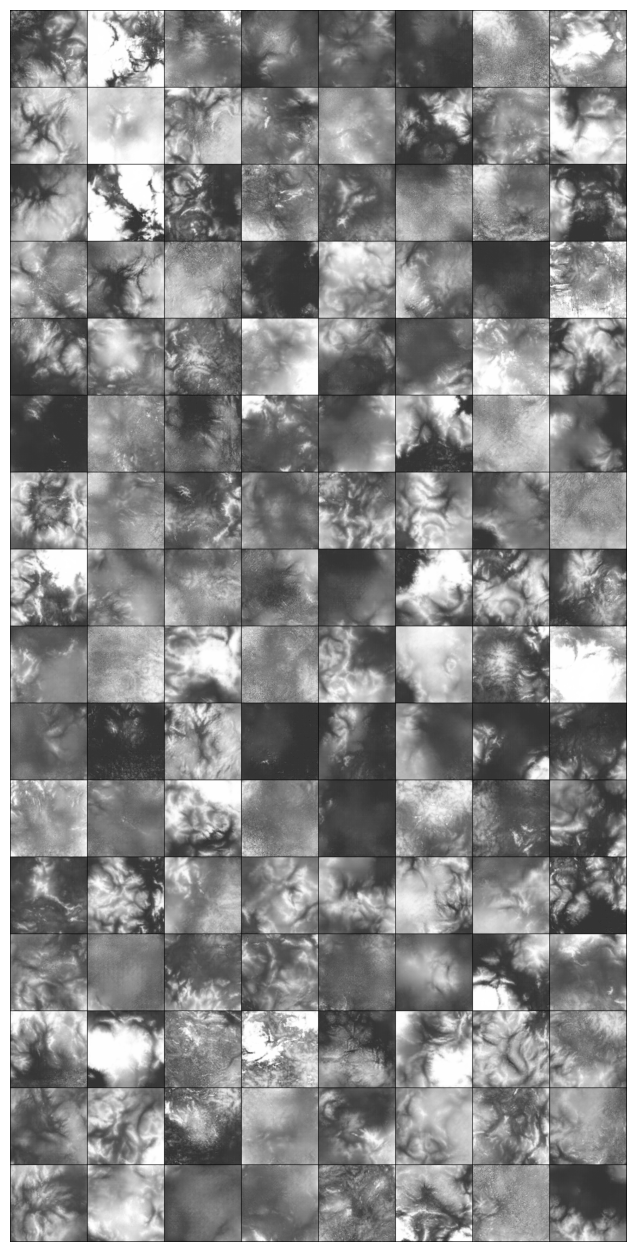

saved epoch 361


In [37]:
img_list = []
G_losses = np.load("/kaggle/input/losses/kaggle/working/losses/G_losses.pkl", allow_pickle = True)
D_losses = np.load("/kaggle/input/losses/kaggle/working/losses/D_losses.pkl", allow_pickle = True)
D_real_losses = np.load("/kaggle/input/losses/kaggle/working/losses/D_real_losses.pkl", allow_pickle = True)
D_fake_losses = np.load("/kaggle/input//losses/kaggle/working/losses/D_fake_losses.pkl", allow_pickle = True)
iters = 0

print("Starting Training Loop...")

for epoch in range(361,num_epochs+1):
    for i, data in enumerate(dataloader, 0):
        for _ in range (5):
            ##train with all reals
            netD.zero_grad()
            #setup batch
            real_cpu = data.to(device)
            b_size = real_cpu.size(0)
    #         label = torch.full((b_size,1), real_label, dtype=torch.float, device = device)

            #fwd pass thru D
            output = netD(real_cpu)
            errD_real = -torch.mean(output)
            D_x = output.mean().item()
            ##train with all fakes
            #gen batch of latent

            noise = torch.randn(b_size, 100,1,1, device = device)
            #generate fake batch by G
            fake = netG(noise)
            output = netD(fake.detach())
            D_G_z1 = output.mean().item()
            errD_fake = torch.mean(output)
            #compute errD as sum of fake and real
            errD = errD_fake + errD_real

            #update D
            errD.backward()
            optimizerD.step()
            
            with torch.no_grad():
                for name, param in netD.named_parameters():
                    if 'batch' not in name:
                        param.clamp_(-0.01,0.01)

        
        ############################
        # (2) Update G network
        ###########################
        
        netG.zero_grad()
#         label.fill_(real_label)# fake labels are real for generator cost
        noise = torch.randn(b_size, 100,1,1, device = device)
        fake = netG(noise)
        output = netD(fake)
        errG = -torch.mean(output)
#         print(errG)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if i%50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        D_real_losses.append(errD_real.item())
        D_fake_losses.append(errD_fake.item())
        
    print(f"EPOCH_{epoch} OUTPUT")
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    grid_image = vutils.make_grid(torch.cat(img_list), padding = True, normalize = True)
    processed = np.transpose(grid_image.cpu().detach().numpy(), (1, 2, 0))
    wandb.log({f"generated-{epoch}" : wandb.Image(processed)})
    print(f"logged-{epoch}")
    fig = plt.figure(figsize=(16,16))
    plt.axis("off")
#     ims = [[ plt.imshow(np.transpose(i,(1,2,0)), cmap = 'gray')]for i in img_list]
    plt.imshow(np.transpose(grid_image, (1, 2, 0)), cmap='gray')
    plt.show()

    img_list = []
        
    
    PATH = f"/kaggle/working/checkpoints/{epoch}_GAN.pt"
    torch.save({

        'Gen_state_dict': netG.state_dict(),
        'Disc_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
    }, PATH)
    print(f"saved epoch {epoch}")
    iters += 1
PATH = f"/kaggle/working/last_GAN.pt"
torch.save({

    'Gen_state_dict': netG.state_dict(),
    'Disc_state_dict': netD.state_dict(),
    'optimizerG_state_dict': optimizerG.state_dict(),
    'optimizerD_state_dict': optimizerD.state_dict(),
}, PATH)

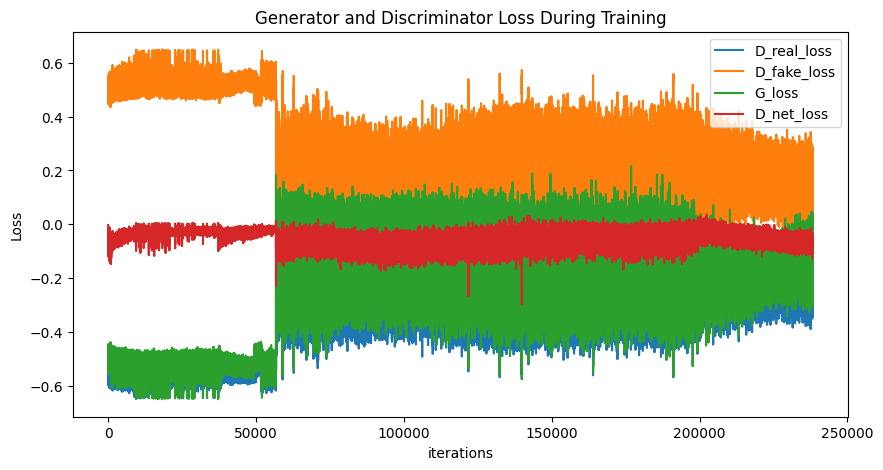

In [38]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(D_real_losses, label = "D_real_loss")
plt.plot(D_fake_losses, label = "D_fake_loss")
plt.plot(G_losses,label="G_loss")
plt.plot(D_losses,label="D_net_loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Losses graph.png")
plt.show()

In [39]:
!zip -r checkpoints.zip /kaggle/working/checkpoints

  adding: kaggle/working/checkpoints/ (stored 0%)
  adding: kaggle/working/checkpoints/361_GAN.pt (deflated 10%)


In [40]:
img_list = []
save_dir = 'images'
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
os.makedirs(save_dir, exist_ok = True)
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
for i in range(min(num_images, fake.size(0))):
    print("saved", i)
    vutils.save_image(fake[i], f"{save_dir}/image_{i}.png")
fig = plt.figure(figsize=(16,16))
plt.axis("off")
ims = [[ plt.imshow(np.transpose(i,(1,2,0)), cmap = 'gray')]for i in img_list]
plt.show()

NameError: name 'num_images' is not defined

In [ ]:
!mkdir losses

In [ ]:
import pickle
with open('/kaggle/working/losses/G_losses.pkl', 'wb') as f:
    pickle.dump(G_losses, f)

with open('/kaggle/working/losses/D_losses.pkl', 'wb') as f:
    pickle.dump(D_losses, f)

with open('/kaggle/working/losses/D_real_losses.pkl', 'wb') as f:
    pickle.dump(D_real_losses, f)
    
with open('/kaggle/working/losses/D_fake_losses.pkl', 'wb') as f:
    pickle.dump(D_fake_losses, f)

In [ ]:
!zip -r losses.zip /kaggle/working/losses